# Volume 3: K-Means Clustering.
    Kameron Lightheart
    MATH 404
    2/11/2020

In [125]:
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, ClusterMixin
import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from sklearn.cluster import KMeans as sk_KMeans
from mpl_toolkits.mplot3d import Axes3D# You might want this for Problem 2.
%matplotlib inline

In [62]:
plt.rcParams["figure.dpi"] = 200

## Problem 1

Write a `KMeans` class for doing basic $k$-means clustering.
Implement the following methods, following `sklearn` class conventions.
1. `__init__()`: Accept a number of clusters $k$, a maximum number of iterations, and a convergence tolerance.
Store these as attributes.

2. `fit()`: Accept an $m \times n$ matrix $X$ of $m$ data points with $n$ features.
Choose $k$ random rows of $X$ as the initial cluster centers.
Run the $k$-means iteration until consecutive centers are within the convergence tolerance, or until iterating the maximum number of times.
Save the cluster centers as attributes.
If a cluster is empty, reassign the cluster center as a random row of $X$.

3. `predict()`: Accept an $l \times n$ matrix $X$ of data.
Return an array of $l$ integers where the $i$th entry indicates which cluster center the $i$th row of $X$ is closest to.

Test your class on the iris data set (`sklean.datasets.load_iris()`) after reducing the data to two principal components (with `sklearn.decomposition.PCA`).
Plot the data, coloring by cluster.

In [118]:
class KMeans(BaseEstimator, ClusterMixin):
    """Basic k-means clustering class."""
    def __init__(self, n_clusters=8, max_iter=100, tol=1e-5, normalize=False):
        """Store clustering algorithm parameters.
        
        Parameters:
            n_clusters (int): How many clusters to compute.
            max_iter (int): The maximum number of iterations to compute.
            tol (float): The convergence tolerance.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.normalize = normalize        # This is for Problem 2.
    
    def fit(self, X, y=None):
        """Compute the cluster centers from random initial conditions.
        
        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        n,m = X.shape
        cluster_dict = dict()
        indices = np.random.randint(0, n, self.n_clusters)
        self.cluster_centers = X[indices]
        for i in range(self.max_iter):
            for j in range(n):
                cluster_index = np.argmin([np.linalg.norm(X[j] - center) for center in self.cluster_centers])
                if cluster_index in cluster_dict.keys():
                    cluster_dict[cluster_index].append(j)
                else:
                    cluster_dict[cluster_index] = [j]
            old_clusters = self.cluster_centers
            for k in range(self.n_clusters):
                if k in cluster_dict.keys():
                    X_indices = cluster_dict[k]
                    self.cluster_centers[k] = np.mean(X[X_indices], axis=0)
                else:
                    self.cluster_centers[k] = np.random.randint(0, n)
            
            if normalize:
                self.cluster_centers = normalize(self.cluster_centers)
            
            if np.linalg.norm(old_clusters - self.cluster_centers) < self.tol:
                break
    
    def predict(self, X):
        """Classify each entry of X based on which cluster center it belongs to.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        
        Returns:
            ((n_samples) ndarray): Integer labels from 0 to n_clusters for each entry of X.
        """
        n,m = X.shape
        labels = np.empty(n)
        for i in range(n):
            labels[i] = np.argmin([np.linalg.norm(X[i] - center) for center in self.cluster_centers])
            
        return labels
    
    def fit_predict(self, X, y=None):
        """Fit to the data and return the resulting labels.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        self.fit(X)
        return self.predict(X)

Text(0, 0.5, 'Second Principal Component')

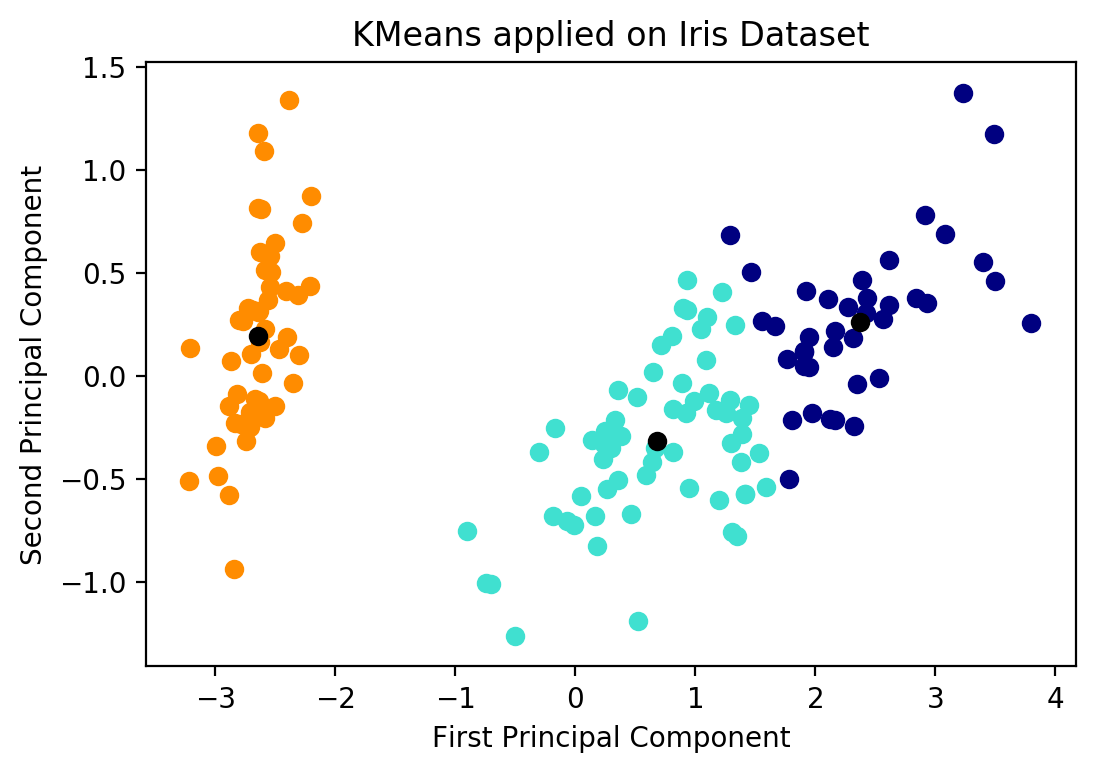

In [93]:
iris = datasets.load_iris()
X = iris.data

pca = PCA(2)
X = pca.fit_transform(X)
kmeans = KMeans(3)
kmeans.fit(X)
y = kmeans.predict(X)
y = [int(this) for this in y]

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']

for i in range(len(X)):
    plt.scatter(X[i,0], X[i,1], color=colors[y[i]])
means = kmeans.cluster_centers
plt.scatter(means[:,0], means[:,1], color="black")
plt.title("KMeans applied on Iris Dataset")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

## Problem 2

Modify `KMeansfit()` so that if `normalize` is `True`, the cluster centers are normalized at each iteration.

Cluster the earthquake data in three dimensions by converting the data from spherical coordinates to euclidean coordinates on the sphere.
1. Convert longitude and latitude to radians, then to spherical coordinates.
(Hint: `np.deg2rad()` may be helpful.)
2. Convert the spherical coordinates to euclidean coordinates in $\mathbb{R}^3$.
3. Use your `KMeans` class with normalization to cluster the euclidean coordinates.
4. Translate the cluster center coordinates back to spherical coordinates, then to degrees.
5. Plot the data, coloring by cluster.
Also mark the cluster centers.

In [123]:
data = np.load("earthquake_coordinates.npy")
theta = (np.pi / 180) * data[:,0]
phi = (np.pi / 180) * data[:,1]
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)
euc_data = np.array(list(zip(x,y,z)))
kmeans = KMeans(n_clusters=15, normalize=True)
kmeans.fit(euc_data)
clusters = kmeans.cluster_centers
pred = kmeans.predict(euc_data)

Text(0, 0.5, 'Latitude')

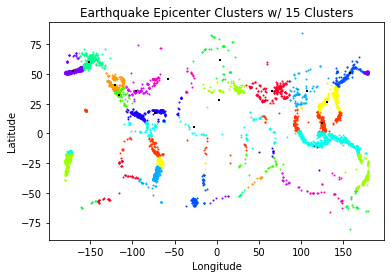

In [164]:
x,y,z = clusters[:,0], clusters[:,1], clusters[:,2]
theta, phi = np.arctan2(y,x), np.arccos(z)
euc_clusters = np.rad2deg(np.array(list(zip(theta,phi))))

NUM_COLORS = 15

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i in range(len(data)):
    plt.scatter(data[i,0], data[i,1], color=scalarMap.to_rgba(int(pred[i])), s=1)
plt.scatter(euc_clusters[:,0], euc_clusters[:,1], color="black", marker="+", s=3)
plt.title("Earthquake Epicenter Clusters w/ 15 Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

## Problem 3

Write a function that accepts an image array (of shape $(m,n,3)$), an integer number of clusters $k$, and an integer number of samples $S$.
Reshape the image so that each row represents a single pixel.
Choose $S$ pixels to train a $k$-means model on with $k$ clusters.
Make a copy of the original picture where each pixel has the same color as its cluster center.
Return the new image.
For this problem, you may use `sklearn.cluster.KMeans` instead of your `KMeans` class.

Test your function on some of the provided NASA images.

In [161]:
def quantize_image(im, n_clusters=4, n_samples=50):
    """Cluster the pixels of the image 'im' by color.
    Return a copy of the image where each pixel is replaced by the value
    of its cluster center.
    
    Parameters:
        im ((m,n,3) ndarray): an image array.
        n_clusters (int): the number of k-means clusters.
        n_samples (int): the number of pixels to train the k-means model on.
    
    Returns:
        ((m,n,3) ndarray): the quantized image.
    """
    model = sk_KMeans(n_clusters)
    n,m,p = im.shape
    im_reshaped = im.reshape(n*m,p)
    model.fit(im_reshaped)
    labels = model.predict(im_reshaped)
    clusters = model.cluster_centers_
    new_img = np.zeros_like(im_reshaped)
    for i in range(len(im_reshaped)):
        new_img[i] = clusters[labels[i]]
    return new_img.reshape((m,n,p))

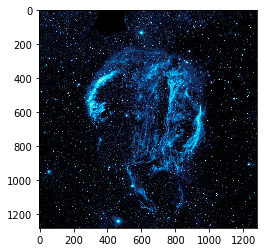

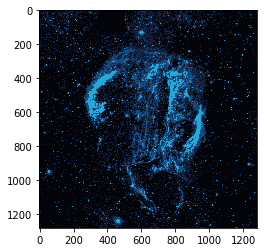

In [162]:
test_img = plt.imread("nasa/cygnus_loop.jpg")
plt.imshow(test_img)
plt.show()
new_img = quantize_image(test_img)
plt.imshow(new_img)
plt.show()